# Component contribution analysis

From the hyperparameter tuning step, we have selected a set of parameters ($\lambda$,  $ \vartheta$, k) with largest **LLPD$_o$**.  

Here we aim to evaluate the contribution of each of the components in the generative model (MEM). The generative model for the ocean microbiome data for the microbial abundance data consists of **geochemical component**, **spatio-temporal components indicating geographical location, ocean depth and time** and **species-species interaction component**. To understand their  contribution in the MEM, we drop each of the specific component in the generative model, estimate the variational posterior and then evaluate the model performance in terms of the **out of sample log-likelihood predictive density (LLPD$_o$)**.


Steps of the analysis
 + Define component excluded generative model
 + Python script for the variational posterior estimation: **component_contribution_fit.py**
 + Script to call component excluded generative model  
 + Evaluate the model in terms of the **LLPD$_o$**

 
#### Component excluded generative model
We have defined the component excluded stan model (see stan_model folder) in the following files:
 + **NB_microbe_ppc.stan** : Full model [Model = 0]
 + **NB_microbe_ppc-1.stan** : Province component dropped  [Model = 1]
 + **NB_microbe_ppc-2.stan** : Biome component dropped  [Model = 2]
 + **NB_microbe_ppc-3.stan** : Quarter/Time component dropped  [Model = 3]
 + **NB_microbe_ppc-G.stan** : Geochemical component dropped  [Model = 4]
 + **NB_microbe_ppc_nointer.stan** : Species-species interaction component dropped  [Model = 5]

#### Script to evaluate the model
For the chosen set of hyperparameters, we compute the variational posterior of each the **component excluded generative model** for **twenty** different initialization. We have saved the command calling **component_contribution_fit.py** for each of the  **component excluded generative model** in the file **mem_component_contribution** (see the python cript below to generate the file).

A line in the file **mem_component_contribution** calls the python script **component_contribution_fit.py** for a given choice of the parameters. 

*module purge ; module load slurm gcc python3 ; OMP_NUM_THREADS=1 python3 component_contribution_fit.py 100.0 0.219 0.06503 0.1 200 1 0 1.0 > logfile/1.log 2>&1*

Input parameters for a setting includes **latent rank (k),  $\lambda$,  $\vartheta$, test sample proportion, variational posterior sample size,  sub-settings unique ID (1-20), model type  and setting seed**. 


#### Parameter estimation 
We run the script on server using the command:
*sbatch -N [#node] -p [#partition] disBatch.py -t [#task on each node] [script_file]*
Example: *sbatch -N 10 -p ccm disBatch.py -t 25 mem_component_contribution*




#### Model output analysis
Evaluate each of the **component excluded generative model** based on the $LLPD_o$. Let us consider our model output is saved in the folder **CContribution**. To compare the model, we load the output file and compute the $LLPD_o$ for each model. 

In [1]:
## Load all the required python module for the analysis 
import glob 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hiplot as hip
import os 
import pickle as pkl
import copy 
%matplotlib inline
## We have saved the variational posterior estimated from hyperparameter tuning in [HPcheck] folder 
#print("Current working directory:", os.getcwd())  # Check where the script is running from
fname_o = glob.glob('../results/results_op/component/models/extracted/*model_nb_cvtest.pkl') 
print("Looking for files in:", fname_o)
print("Loaded files:", fname_o) #Check if the file is loaded

Looking for files in: ['../results/results_op/component/models/extracted/30_0_10_model_nb_cvtest.pkl', '../results/results_op/component/models/extracted/30_4_16_model_nb_cvtest.pkl', '../results/results_op/component/models/extracted/30_0_4_model_nb_cvtest.pkl', '../results/results_op/component/models/extracted/30_1_1_model_nb_cvtest.pkl', '../results/results_op/component/models/extracted/30_0_5_model_nb_cvtest.pkl', '../results/results_op/component/models/extracted/30_2_19_model_nb_cvtest.pkl', '../results/results_op/component/models/extracted/30_0_19_model_nb_cvtest.pkl', '../results/results_op/component/models/extracted/30_2_10_model_nb_cvtest.pkl', '../results/results_op/component/models/extracted/30_5_2_model_nb_cvtest.pkl', '../results/results_op/component/models/extracted/30_5_8_model_nb_cvtest.pkl', '../results/results_op/component/models/extracted/30_0_9_model_nb_cvtest.pkl', '../results/results_op/component/models/extracted/30_4_19_model_nb_cvtest.pkl', '../results/results_op/

In [2]:
import glob
import pickle as pkl
import pandas as pd
import numpy as np
import os

# Define the path to your models folder
MODELS_FOLDER = "../results/results_op/component/models/extracted"  # Update as needed

# Ensure the folder exists
if not os.path.exists(MODELS_FOLDER):
    raise FileNotFoundError(f"❌ Folder NOT found: {MODELS_FOLDER}")

# Find all .pkl model files
model_files = glob.glob(os.path.join(MODELS_FOLDER, "*.pkl"))
print(f"✅ Found {len(model_files)} model files.")

# Check if no files found
if not model_files:
    raise FileNotFoundError(f"❌ No .pkl files found in: {MODELS_FOLDER}")

# Extract relevant data from each model file
model_data = []

for model_file in model_files:
    with open(model_file, "rb") as file:
        try:
            # Load model output
            data = pkl.load(file)

            if len(data) < 18:
                print(f"⚠️ Skipping {model_file} - Unexpected structure")
                continue

            # Extract key values
            holdout_mask = data[0]  # Matrix indicating test data
            l = data[4]  # Lambda
            sp_mean = data[6]
            sp_var = data[7]
            uid = data[9]
            model_type = data[10]
            cv_test = data[13]  # Log-likelihood values for test samples

            # Compute LLPD: Only consider test samples (holdout_mask == 1)
            se_index = holdout_mask == 1  # Get test sample indices
            if isinstance(cv_test, np.ndarray) and np.any(se_index):  # Check if data exists
                llpd = np.mean(cv_test[se_index])  # Compute mean LLPD
            else:
                llpd = np.nan  # Set as NaN if unavailable

            # Store extracted values
            model_data.append([model_file, model_type, l, sp_mean, sp_var, llpd, uid])

        except Exception as e:
            print(f"❌ Error processing {model_file}: {e}")

# Convert list to DataFrame
columns = ['Filename', 'Model', 'Lambda', 'Mean SP', 'Variance SP', 'LLPD', 'UID']
df_models = pd.DataFrame(model_data, columns=columns)

# Sort by LLPD (higher is better)
df_models_sorted = df_models.sort_values(by="LLPD", ascending=False)

# Display styled DataFrame
from IPython.display import display
styled_df = df_models_sorted.style.background_gradient(cmap="viridis").set_properties(**{'text-align': 'center'})
display(styled_df)


✅ Found 120 model files.


,Filename,Model,Lambda,Mean SP,Variance SP,LLPD,UID
10,../results/results_op/component/models/extracted/30_0_9_model_nb_cvtest.pkl,200,100,0.060596,0.040816,20.343114,30
88,../results/results_op/component/models/extracted/30_3_7_model_nb_cvtest.pkl,200,100,0.060596,0.040816,20.335857,30
27,../results/results_op/component/models/extracted/30_1_0_model_nb_cvtest.pkl,200,100,0.060596,0.040816,20.321552,30
87,../results/results_op/component/models/extracted/30_5_9_model_nb_cvtest.pkl,200,100,0.060596,0.040816,20.260990,30
18,../results/results_op/component/models/extracted/30_2_13_model_nb_cvtest.pkl,200,100,0.060596,0.040816,20.249556,30
73,../results/results_op/component/models/extracted/30_4_15_model_nb_cvtest.pkl,200,100,0.060596,0.040816,20.247311,30
95,../results/results_op/component/models/extracted/30_3_10_model_nb_cvtest.pkl,200,100,0.060596,0.040816,20.198444,30
97,../results/results_op/component/models/extracted/30_1_2_model_nb_cvtest.pkl,200,100,0.060596,0.040816,20.190195,30
2,../results/results_op/component/models/extracted/30_0_4_model_nb_cvtest.pkl,200,100,0.060596,0.040816,20.133079,30
38,../results/results_op/component/models/extracted/30_2_14_model_nb_cvtest.pkl,200,100,0.060596,0.040816,20.050224,30


In [3]:
import pickle 
for file in fname_o:
    print(f"Inspecting file: {os.path.relpath(file)}")
    try:
        with open(file, "rb") as f:
            data = pickle.load(f)
        
        # Check if the data is iterable (e.g., list, tuple, dict)
        if isinstance(data, (list, tuple)):
            print(f"File contains a {type(data).__name__} with {len(data)} elements.")
            for i, element in enumerate(data):
                print(f"  Element {i}: Type={type(element)}")
        elif isinstance(data, dict):
            print(f"File contains a dictionary with {len(data)} keys.")
            for key, value in data.items():
                print(f"  Key='{key}': Type={type(value)}")
        else:
            print(f"File contains a single object of type {type(data).__name__}.")
    except Exception as e:
        print(f"Error while reading {file}: {e}")
    print("-" * 50)

Inspecting file: ../results/results_op/component/models/extracted/30_0_10_model_nb_cvtest.pkl
File contains a list with 18 elements.
  Element 0: Type=<class 'numpy.ndarray'>
  Element 1: Type=<class 'int'>
  Element 2: Type=<class 'int'>
  Element 3: Type=<class 'int'>
  Element 4: Type=<class 'int'>
  Element 5: Type=<class 'int'>
  Element 6: Type=<class 'float'>
  Element 7: Type=<class 'float'>
  Element 8: Type=<class 'float'>
  Element 9: Type=<class 'int'>
  Element 10: Type=<class 'int'>
  Element 11: Type=<class 'numpy.ndarray'>
  Element 12: Type=<class 'numpy.ndarray'>
  Element 13: Type=<class 'numpy.ndarray'>
  Element 14: Type=<class 'numpy.ndarray'>
  Element 15: Type=<class 'numpy.ndarray'>
  Element 16: Type=<class 'int'>
  Element 17: Type=<class 'int'>
--------------------------------------------------
Inspecting file: ../results/results_op/component/models/extracted/30_4_16_model_nb_cvtest.pkl
File contains a list with 18 elements.
  Element 0: Type=<class 'numpy.n

In [4]:
# Extract model output and compute LLPD
out = {}

for i in range(len(fname_o)):
    if (i % 20) == 0:
        print(i)

    # Load the model file
    with open(fname_o[i], "rb") as file:
        [holdout_mask, Yte_sample, llpd, n_test, l, m_seed, sp_mean,
         sp_var, h_prop, uid, nsample_o, Yte_fit,
         cv_test, Y, muest, Yte_cv, Yte_lpmf, kl_comp] = pkl.load(file)

    se_index = holdout_mask == 1.

    # Compute LLPD
    temp_ll = cv_test[se_index]
    temp_ll = np.mean(temp_ll)

    # Extract mtype correctly
    filename = os.path.basename(fname_o[i])  # Extract only the filename
    filename_parts = filename.split('_')  # Split by '_'

    if len(filename_parts) >= 3:
        mtype = int(filename_parts[2])  # Extract the third part (e.g., "10" from "30_0_10_model_nb_cvtest.pkl")
    else:
        raise ValueError(f"Unexpected filename format: {filename}")

    # Compute error
    error = np.mean(np.power(Y - muest, 2)[se_index])

    # Store results
    out[i] = [i, l, sp_mean, sp_var, temp_ll, uid, mtype]

print("Processing complete!")


0
20
40
60
80
100
Processing complete!


In [15]:
print("Sample entry in 'out':", next(iter(out.values())))

Sample entry in 'out': [0, 100, 0.06059627021136009, 0.0408163265306122, -3.3357373475427203, 30, 0, 10]


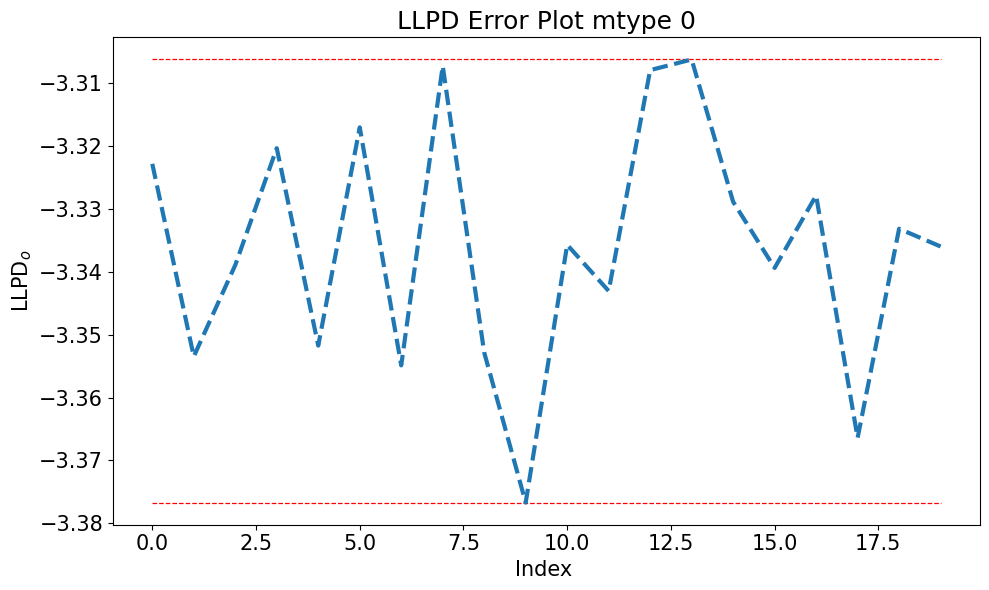

Saved plot: ../results/results_op/plots/llpd_error_plot_mtype_0.png


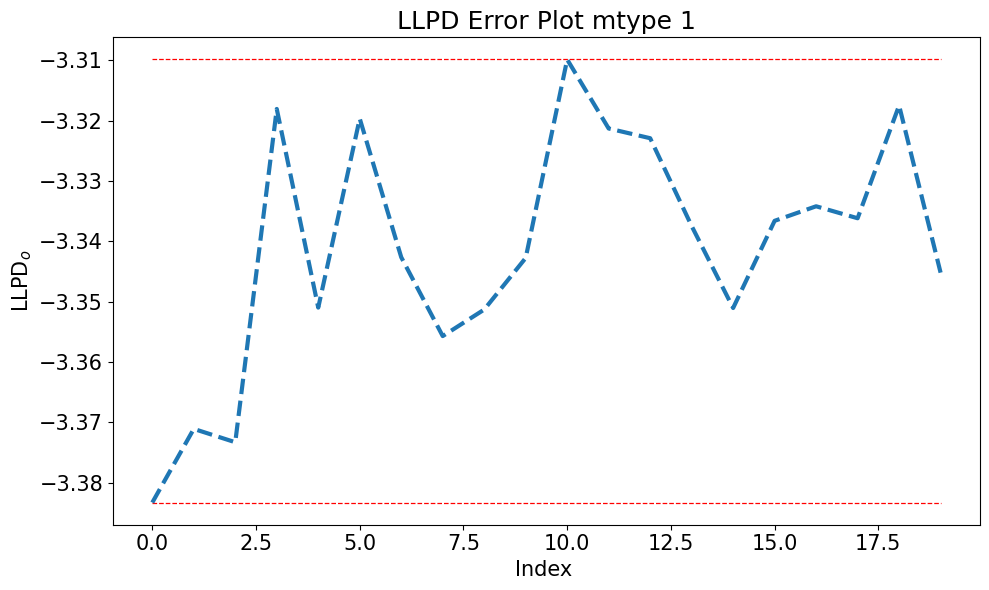

Saved plot: ../results/results_op/plots/llpd_error_plot_mtype_1.png


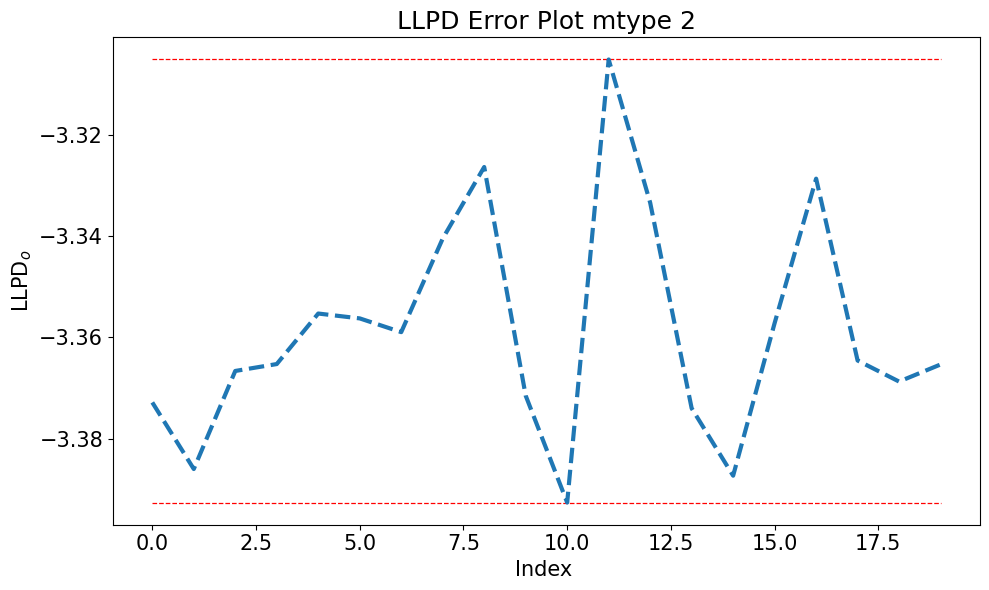

Saved plot: ../results/results_op/plots/llpd_error_plot_mtype_2.png


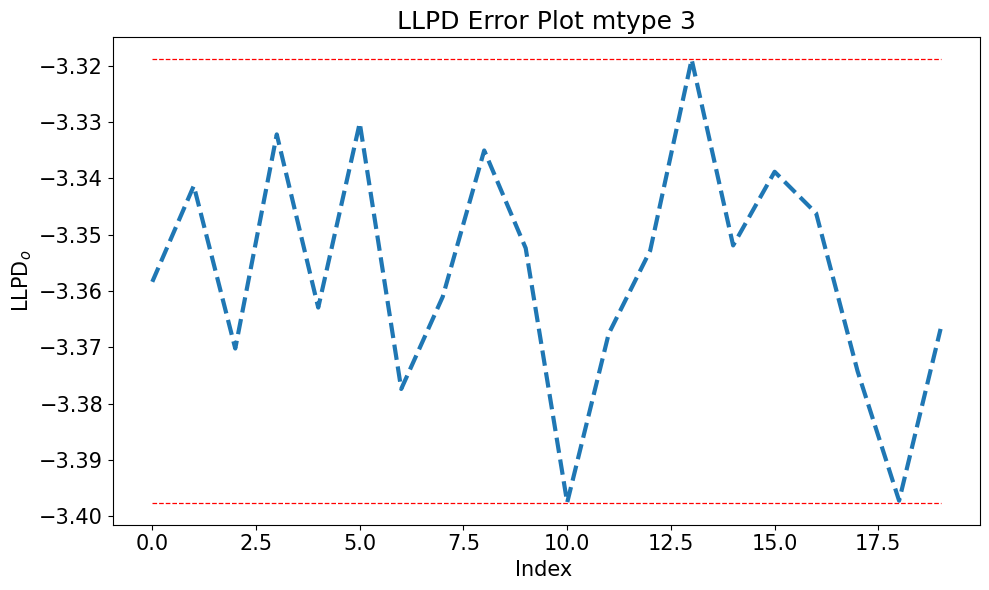

Saved plot: ../results/results_op/plots/llpd_error_plot_mtype_3.png


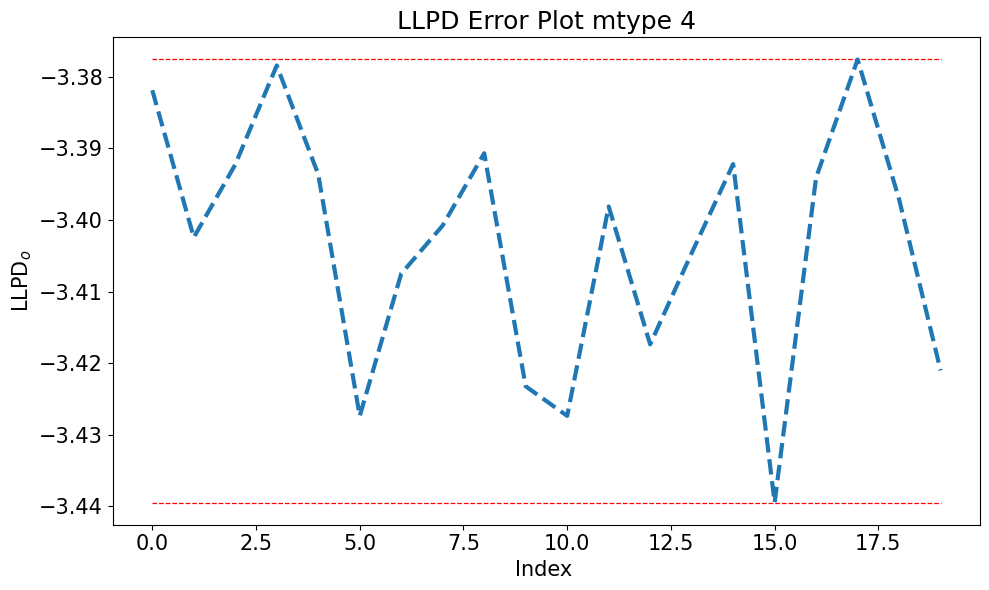

Saved plot: ../results/results_op/plots/llpd_error_plot_mtype_4.png


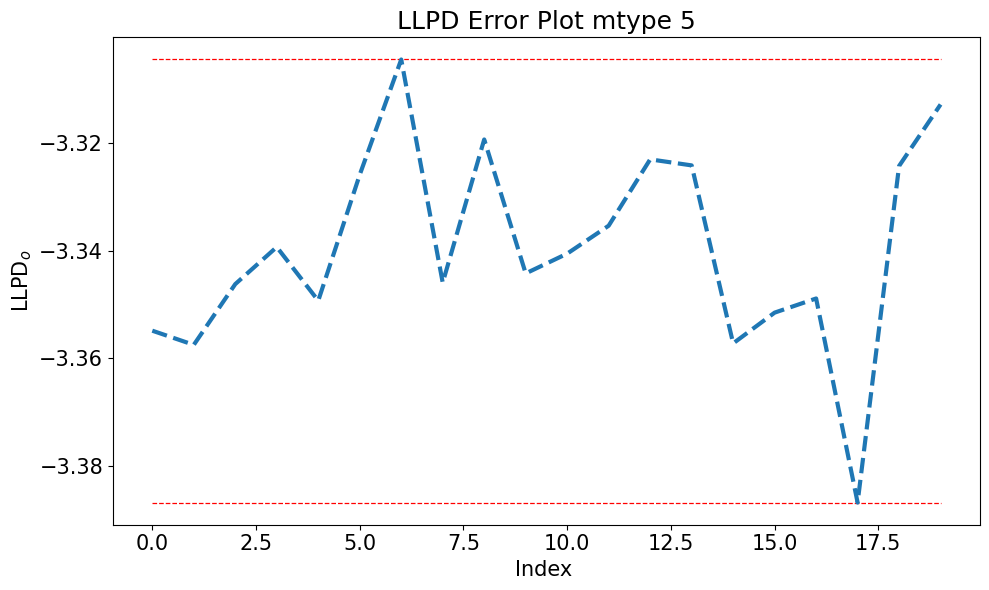

Saved plot: ../results/results_op/plots/llpd_error_plot_mtype_5.png


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the folder where plots will be saved
figfol = "../results/results_op/plots/"
columns = ["Index", "l", "sp_mean", "sp_var", "llpd", "uid", "number1", "number2"]
df = pd.DataFrame.from_dict(out, orient="index", columns=columns)
# Ensure the directory exists
os.makedirs(figfol, exist_ok=True)

# Unique values of mtype (number1)
unique_number1 = sorted(df["number1"].unique())

for num1 in unique_number1:
    subset = df[df["number1"] == num1]

    # Compute mean and standard deviation of LLPD per index (number2)
    out_mean = subset.groupby("number2")["llpd"].agg(["mean", "std"])

    # Standard error (assuming n=5 samples per setting)
    sderr = out_mean["std"] / np.sqrt(5)

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.errorbar(
        np.array(out_mean.index), 
        out_mean["mean"], 
        yerr=sderr, 
        label=f"Error plot (mtype={num1})",
        ecolor="r", 
        elinewidth=0.99, 
        capsize=1, 
        linewidth=3, 
        linestyle="--"
    )

    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.set_xlabel("Index ", fontsize=15)
    ax.set_ylabel(r"LLPD$_o$", fontsize=15)
    ax.set_title(f"LLPD Error Plot mtype {num1}", fontsize=18)

    # Optional horizontal reference lines
    low_lim = out_mean["mean"].min()
    h_lim = out_mean["mean"].max()
    ax.hlines(low_lim, 0, 19, colors="r", linewidth=0.9, linestyle="--")
    ax.hlines(h_lim, 0, 19, colors="r", linewidth=0.9, linestyle="--")

    fig.tight_layout()

    # Save the figure
    plot_filename = os.path.join(figfol, f"llpd_error_plot_mtype_{num1}.png")
    fig.savefig(plot_filename, dpi=400)
    
    # Show the plot
    plt.show()

    print(f"Saved plot: {plot_filename}")


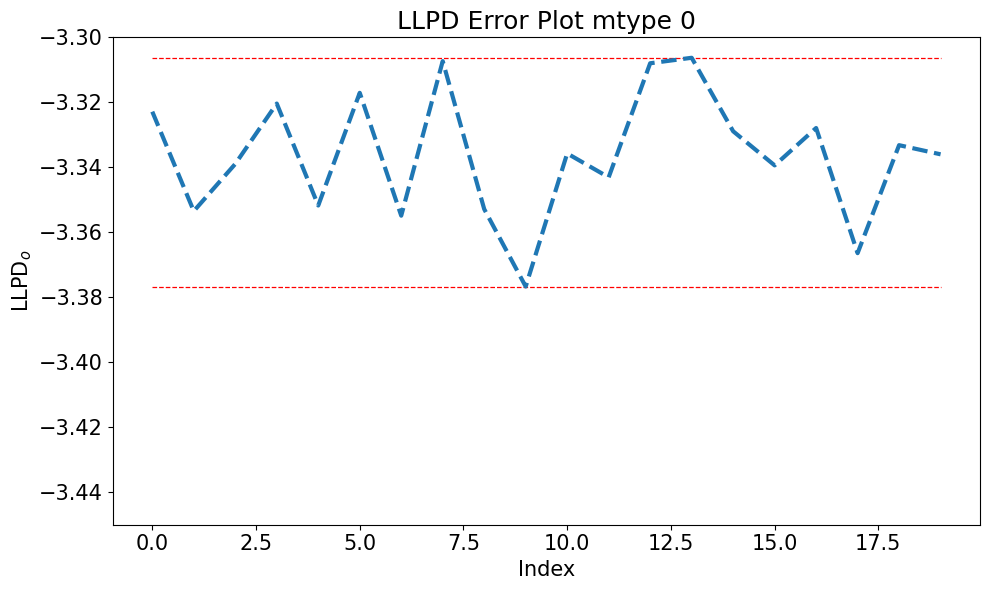

Saved plot: ../results/results_op/plots/llpd_error_plot_mtype_0.png


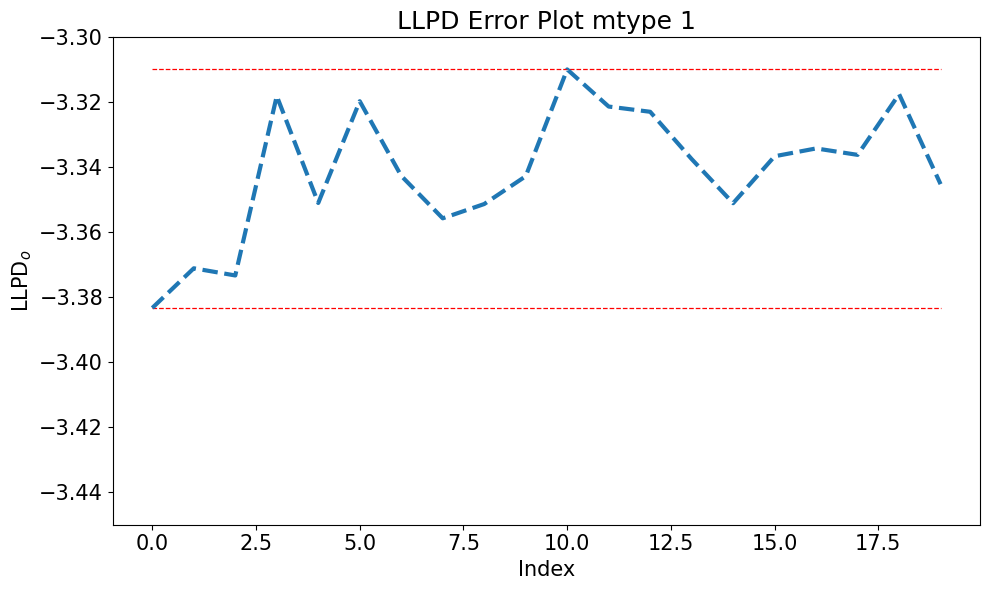

Saved plot: ../results/results_op/plots/llpd_error_plot_mtype_1.png


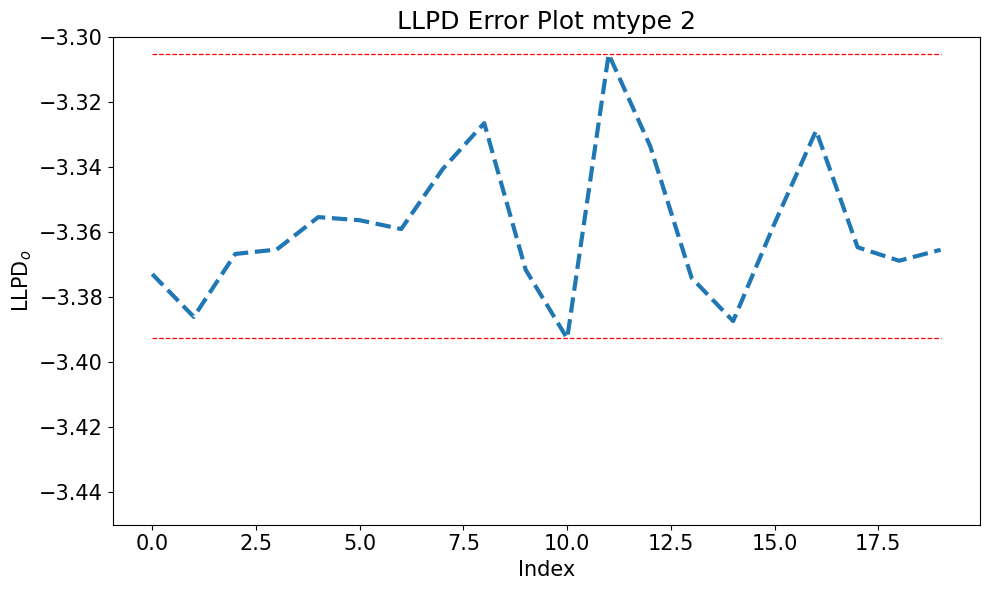

Saved plot: ../results/results_op/plots/llpd_error_plot_mtype_2.png


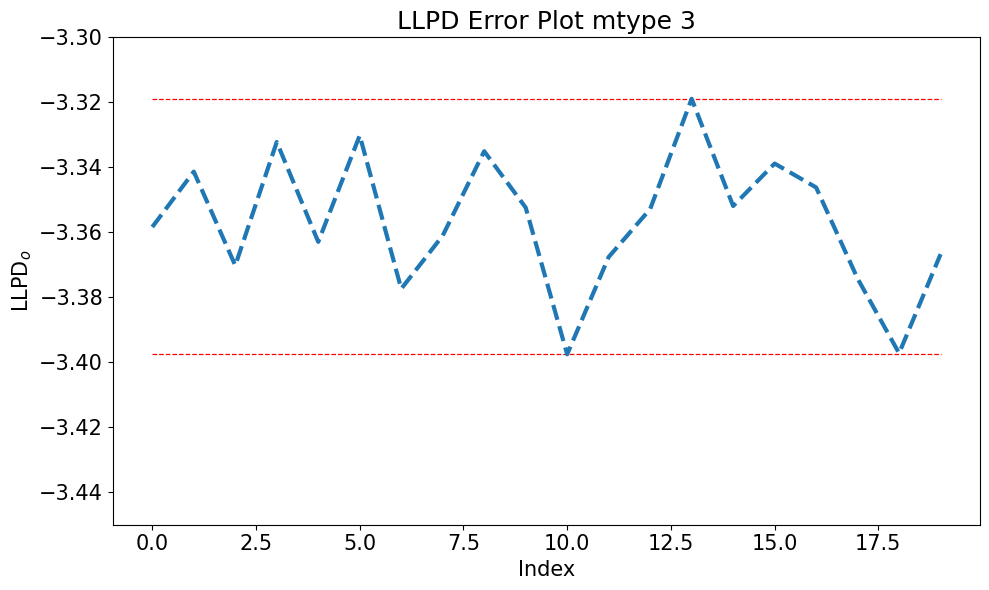

Saved plot: ../results/results_op/plots/llpd_error_plot_mtype_3.png


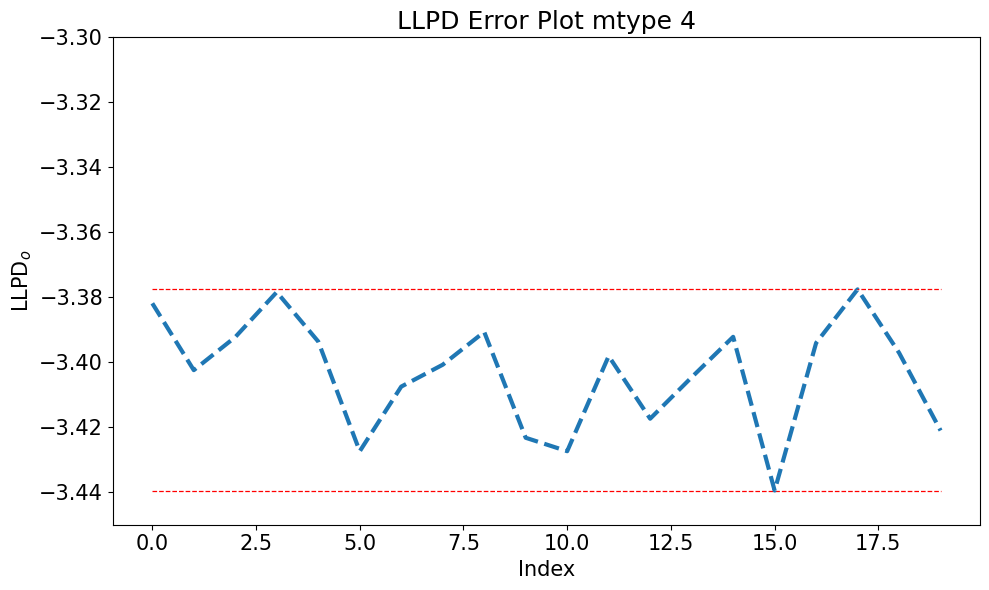

Saved plot: ../results/results_op/plots/llpd_error_plot_mtype_4.png


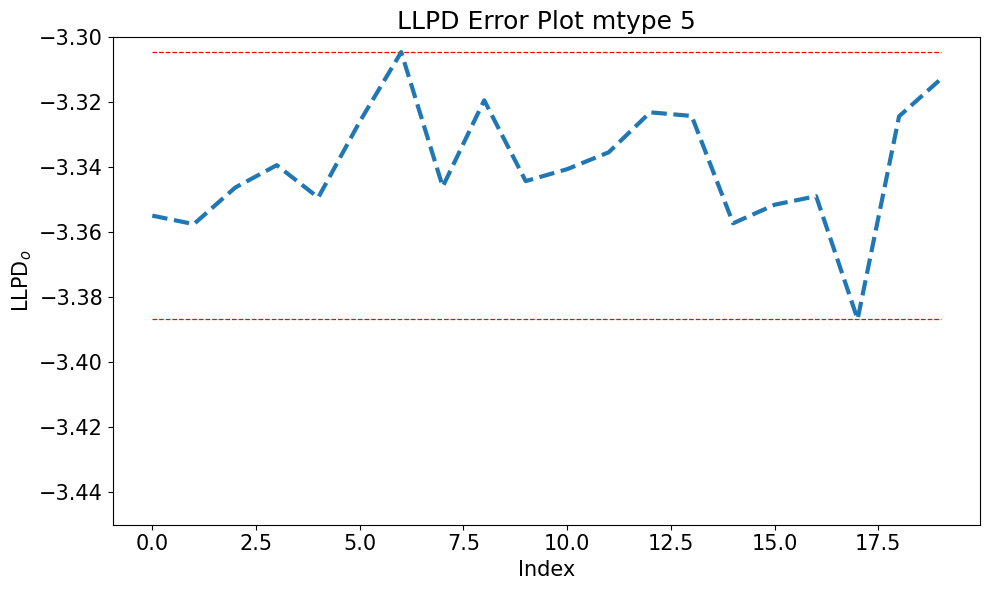

Saved plot: ../results/results_op/plots/llpd_error_plot_mtype_5.png


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the folder where plots will be saved
figfol = "../results/results_op/plots/"

# Ensure the directory exists
os.makedirs(figfol, exist_ok=True)

# Unique values of mtype (number1)
unique_number1 = sorted(df["number1"].unique())

# Set fixed y-axis limits
fixed_ymin, fixed_ymax = -3.45, -3.30

for num1 in unique_number1:
    subset = df[df["number1"] == num1]

    # Compute mean and standard deviation of LLPD per index (number2)
    out_mean = subset.groupby("number2")["llpd"].agg(["mean", "std"])

    # Standard error (assuming n=5 samples per setting)
    sderr = out_mean["std"] / np.sqrt(5)

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.errorbar(
        np.array(out_mean.index), 
        out_mean["mean"], 
        yerr=sderr, 
        label=f"Error plot (mtype={num1})",
        ecolor="r", 
        elinewidth=0.99, 
        capsize=1, 
        linewidth=3, 
        linestyle="--"
    )

    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.set_xlabel("Index", fontsize=15)
    ax.set_ylabel(r"LLPD$_o$", fontsize=15)
    ax.set_title(f"LLPD Error Plot mtype {num1}", fontsize=18)

    # Set fixed y-axis range
    ax.set_ylim(fixed_ymin, fixed_ymax)

    # Optional horizontal reference lines at min/max of each subset
    low_lim = out_mean["mean"].min()
    h_lim = out_mean["mean"].max()
    ax.hlines(low_lim, 0, 19, colors="r", linewidth=0.9, linestyle="--")
    ax.hlines(h_lim, 0, 19, colors="r", linewidth=0.9, linestyle="--")

    fig.tight_layout()

    # Save the figure
    plot_filename = os.path.join(figfol, f"llpd_error_plot_mtype_{num1}.png")
    fig.savefig(plot_filename, dpi=400)

    # Show the plot
    plt.show()

    print(f"Saved plot: {plot_filename}")


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# If the DataFrame is available, process it
if out is not None:
    # Extract 'number1' and 'number2' from the 'sampleid' column
    out["number1"] = out["sampleid"].astype(str).apply(lambda x: int(x.split("_")[0]))
    out["number2"] = out["sampleid"].astype(str).apply(lambda x: int(x.split("_")[1]))

    # Generate boxplots for each 'number1' value
    unique_number1 = sorted(out["number1"].unique())

    for num1 in unique_number1:
        plt.figure(figsize=(12, 6))
        subset = out[out["number1"] == num1]
        sns.boxplot(x="number2", y="llpd", data=subset, palette="husl")
        plt.xlabel("Setting index")
        plt.ylabel("LLPD")
        plt.title(f"LLPD Distribution for number1 = {num1}")
        plt.xticks(rotation=90)
        plt.show()


KeyError: 'sampleid'

In [13]:
out = pkl.load(open('comparison_model', "rb"))
print(type(out))  # Check if it's a dictionary or list
print(len(out))   # Check number of elements
print(out[0])     # Print one entry to inspect its structure


<class 'dict'>
120
[0, 100, 0.06059627021136009, 0.0408163265306122, -3.3357373475427203, 30, 0]


In [14]:
out = pd.DataFrame.from_dict(out, orient='index')
print(out.shape)  # Check if the shape matches (rows, columns)


(120, 7)


In [15]:
# Load the data
out = pkl.load(open('comparison_model', "rb"))

# Convert the dictionary to a DataFrame more carefully
# Method 1: Try converting dict values to DataFrame directly
out_df = pd.DataFrame.from_dict(out, orient='index', columns=['Index','rank','lambda','upsilon','llpd','uid','Model'])

# If Method 1 doesn't work, try Method 2:
# First convert dict to list of lists
data_list = [value for value in out.values()]
out_df = pd.DataFrame(data_list, columns=['Index','rank','lambda','upsilon','llpd','uid','Model'])

# Display the first 20 rows
print(out_df.head(20))

    Index  rank    lambda   upsilon      llpd  uid  Model
0       0   100  0.060596  0.040816 -3.335737   30      0
1       1   100  0.060596  0.040816 -3.394061   30      4
2       2   100  0.060596  0.040816 -3.351756   30      0
3       3   100  0.060596  0.040816 -3.371079   30      1
4       4   100  0.060596  0.040816 -3.317078   30      0
5       5   100  0.060596  0.040816 -3.365383   30      2
6       6   100  0.060596  0.040816 -3.336005   30      0
7       7   100  0.060596  0.040816 -3.392644   30      2
8       8   100  0.060596  0.040816 -3.346224   30      5
9       9   100  0.060596  0.040816 -3.319387   30      5
10     10   100  0.060596  0.040816 -3.376695   30      0
11     11   100  0.060596  0.040816 -3.421014   30      4
12     12   100  0.060596  0.040816 -3.345962   30      5
13     13   100  0.060596  0.040816 -3.378402   30      4
14     14   100  0.060596  0.040816 -3.350975   30      1
15     15   100  0.060596  0.040816 -3.364605   30      2
16     16   10

<font color=blue>**Our analysis suggest that the model 0, i.e., MEM is best with highest out of sample LLPD$_o$.** </font>

In [16]:
# First, convert the dictionary to a DataFrame
out_df = pd.DataFrame.from_dict(out, orient='index')

# Now rename the columns
out_df.columns = ['Index', 'rank', 'lambda', 'upsilon', 'llpd', 'uid', 'Model']

# Now we can perform the groupby operation
results = out_df.groupby(['Model'], as_index=False).agg({'llpd': ['mean', 'std']})

print(results)

  Model      llpd          
             mean       std
0     0 -3.336061  0.019514
1     1 -3.341048  0.020001
2     2 -3.358865  0.022243
3     3 -3.356661  0.021063
4     4 -3.403350  0.017467
5     5 -3.339607  0.018942


In [17]:
# Convert dictionary to DataFrame
out_df = pd.DataFrame.from_dict(out, orient='index')

# Rename columns
out_df.columns = ['Index', 'rank', 'lambda', 'upsilon', 'llpd', 'uid', 'Model']

# Now perform the groupby and transform to get the LaTeX output
out_sub = out_df.groupby(['Model'], as_index=False).mean()[['Model','llpd']].transpose()

# Print LaTeX formatted table
print(out_sub.to_latex(float_format="%.4f", bold_rows=True))

\begin{tabular}{lrrrrrr}
\toprule
{} &       0 &       1 &       2 &       3 &       4 &       5 \\
\midrule
\textbf{Model} &  0.0000 &  1.0000 &  2.0000 &  3.0000 &  4.0000 &  5.0000 \\
\textbf{llpd } & -3.3361 & -3.3410 & -3.3589 & -3.3567 & -3.4033 & -3.3396 \\
\bottomrule
\end{tabular}



In [18]:
l,m_seed,sp_mean, sp_var

(100, 0, 0.0408163265306122, 0.1)

In [19]:
# Convert dictionary to DataFrame
out_df = pd.DataFrame.from_dict(out, orient='index')
out_df.columns = ['Index', 'rank', 'lambda', 'upsilon', 'llpd', 'uid', 'Model']

# Sort by LLPD in descending order (highest first) and get the first row
best_model = out_df.sort_values('llpd', ascending=False).iloc[0]

print("Best Model Configuration:")
print(f"Model Type (mtype): {int(best_model['Model'])}")
print(f"Model Seed (mseed): {int(best_model['Index'])}")
print(f"LLPD Score: {best_model['llpd']:.6f}")
print(f"Other parameters:")
print(f"  Lambda: {best_model['lambda']}")
print(f"  Upsilon: {best_model['upsilon']}")
print(f"  Rank: {int(best_model['rank'])}")

Best Model Configuration:
Model Type (mtype): 5
Model Seed (mseed): 86
LLPD Score: -3.304545
Other parameters:
  Lambda: 0.06059627021136009
  Upsilon: 0.0408163265306122
  Rank: 100


In [20]:
# Given values
index = int(best_model['Index']) # your best model's index
mtype = int(best_model['Model'])  # your best model's type
uid = 30    # from the data

# Calculate actual mseed (0-19)
mseed = index % 20  # This gives us which run number it was within its mtype group

print(f"For index {index}:")
print(f"Model Type (mtype): {mtype}")
print(f"Model Seed (mseed): {mseed}")
print(f"UID: {uid}")
print(f"\nExpected filename: {uid}_{mtype}_{mseed}_model_nb_cvtest.pkl")

For index 86:
Model Type (mtype): 5
Model Seed (mseed): 6
UID: 30

Expected filename: 30_5_6_model_nb_cvtest.pkl


In [21]:
# Load and inspect comparison_model file
import pickle as pkl

# Load the data
with open('comparison_model', 'rb') as f:
    data = pkl.load(f)

# Print general information
print("Type of data:", type(data))
print("Number of entries:", len(data))
print("\nStructure of each entry:")
for i in range(3):  # Show first 3 entries
    print(f"\nEntry {i}:")
    print(f"Raw data: {data[i]}")
    print("Interpreted as:")
    print(f"  Index: {data[i][0]}")
    print(f"  Rank: {data[i][1]}")
    print(f"  Lambda: {data[i][2]}")
    print(f"  Upsilon: {data[i][3]}")
    print(f"  LLPD: {data[i][4]}")
    print(f"  UID: {data[i][5]}")
    print(f"  Model Type: {data[i][6]}")

print("\nUnique Model Types:", sorted(set(data[i][6] for i in range(len(data)))))
print("Unique UIDs:", sorted(set(data[i][5] for i in range(len(data)))))

Type of data: <class 'dict'>
Number of entries: 120

Structure of each entry:

Entry 0:
Raw data: [0, 100, 0.06059627021136009, 0.0408163265306122, -3.3357373475427203, 30, 0]
Interpreted as:
  Index: 0
  Rank: 100
  Lambda: 0.06059627021136009
  Upsilon: 0.0408163265306122
  LLPD: -3.3357373475427203
  UID: 30
  Model Type: 0

Entry 1:
Raw data: [1, 100, 0.06059627021136009, 0.0408163265306122, -3.3940612259344527, 30, 4]
Interpreted as:
  Index: 1
  Rank: 100
  Lambda: 0.06059627021136009
  Upsilon: 0.0408163265306122
  LLPD: -3.3940612259344527
  UID: 30
  Model Type: 4

Entry 2:
Raw data: [2, 100, 0.06059627021136009, 0.0408163265306122, -3.351755606155532, 30, 0]
Interpreted as:
  Index: 2
  Rank: 100
  Lambda: 0.06059627021136009
  Upsilon: 0.0408163265306122
  LLPD: -3.351755606155532
  UID: 30
  Model Type: 0

Unique Model Types: [0, 1, 2, 3, 4, 5]
Unique UIDs: [30]
